# Snake Game

This is text

In [ ]:
# standard library
import sys;
import os;
import time;
import asyncio;

# scientific
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import IPython
import ipywidgets

# machine learning
import gymnasium as gym

# add project files to path
%load_ext autoreload
%autoreload 2
sys.path.append(os.path.relpath('..'))
import gym_snakegame

/home/ben/projects/ml/snake/.venv/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


### Setup

In [17]:
# register custom snake environment
env = gym.make("gym_snakegame/SnakeGame-v0", board_size=10, n_channel=1, n_target=1, render_mode='human')

# check environment validity (optional)
# https://gymnasium.farama.org/introduction/create_custom_env/#check-environment-validity
from gymnasium.utils.env_checker import check_env
try:
    check_env(env)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

/home/ben/projects/ml/snake/.venv/lib/python3.12/site-packages/gymnasium/utils/env_checker.py:384: UserWarning: WARN: The environment (<OrderEnforcing<PassiveEnvChecker<SnakeGameEnv<gym_snakegame/SnakeGame-v0>>>>) is different from the unwrapped version (<SnakeGameEnv<gym_snakegame/SnakeGame-v0>>). This could effect the environment checker as the environment most likely has a wrapper applied to it. We recommend using the raw environment for `check_env` using `env.unwrapped`.
  logger.warn(


Environment passes all checks!


/home/ben/projects/ml/snake/.venv/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:297: UserWarning: WARN: ANSI/ASCII rendering should produce a string, got <class 'NoneType'>
  logger.warn(


In [4]:
env = gym.make("gym_snakegame/SnakeGame-v0", board_size=10, n_channel=1, n_target=1, render_mode='ansi')

obs, info = env.reset()
for i in range(10000):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    frame = env.render()
    IPython.display.clear_output(wait=True)
    print(frame)
    if terminated or truncated:
        obs, info = env.reset()
env.close()

Hello! $0


In [7]:
env = gym.make("gym_snakegame/SnakeGame-v0", board_size=10, n_channel=1, n_target=1, render_mode='rgb_array')

env.action_space

Discrete(4)

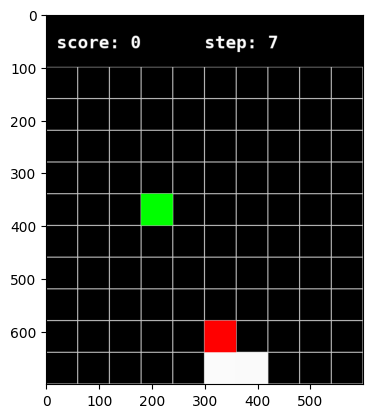

KeyboardInterrupt: 

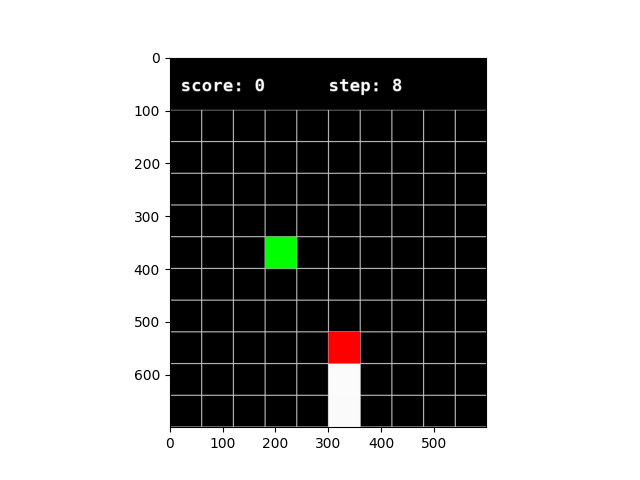

NameError: name 'line1' is not defined

In [12]:
%matplotlib widget

env = gym.make("gym_snakegame/SnakeGame-v0", board_size=10, n_channel=1, n_target=1, render_mode='rgb_array')

fig,ax = plt.subplots(1,1)
hdisplay = IPython.display.display("", display_id=True)

obs, info = env.reset()
for i in range(10000):
    time.sleep(0.01)

    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    frame = env.render()

    ax.imshow(frame);
    hdisplay.update(fig);

    if terminated or truncated:
        obs, info = env.reset()

env.close()
plt.close(fig)

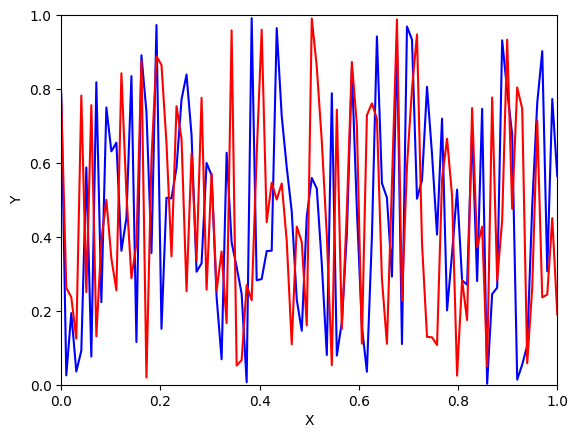

In [ ]:
%matplotlib widget

from IPython import display

# https://stackoverflow.com/a/65400882
def pltsin(ax, *,hdisplay, colors=['b']):
    x = np.linspace(0,1,100)
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            y = np.random.random(size=(100,1))
            line.set_ydata(y)
    else:
        for color in colors:
            y = np.random.random(size=(100,1))
            ax.plot(x, y, color)
    hdisplay.update(fig)


fig,ax = plt.subplots(1,1)
hdisplay = IPython.display.display("", display_id=True)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
for f in range(5):
    pltsin(ax, colors=['b', 'r'], hdisplay=hdisplay)
    time.sleep(1)
    
plt.close(fig)

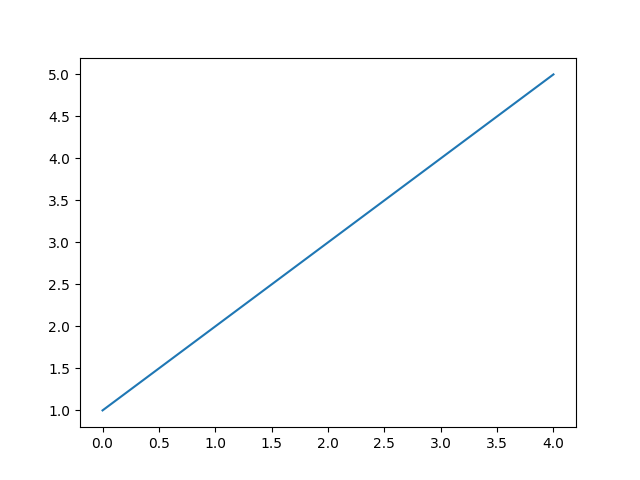

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt;

plt.plot([1,2,3,4,5])
plt.show()

In [13]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# (Your code to create the figure, axes, and initial plot objects)
# ...

# Define the animation function that updates the plot for each frame
def animate(i):
    # Update plot objects (e.g., line data, text) based on frame 'i'
    # ...
    return (line1, line2, txt_title) # Return the objects that were modified

# Create the animation object
anim = animation.FuncAnimation(
    fig, animate, frames=100, interval=20, blit=True
)

# Display the animation as an HTML5 video
HTML(anim.to_jshtml())

NameError: name 'line1' is not defined

In [15]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML
plt.rcParams["animation.html"] = "jshtml"
plt.ioff() #needed so the second time you run it you get only single plot

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.1)
line, = ax.plot(x, np.sin(x))
z = x.size

def animate(i):
    line.set_ydata(np.sin(x - 2*np.pi*i / z)) 
    return line,

ani = animation.FuncAnimation(
    fig, animate,
    frames = z,
    blit=True)
ani